In [1]:
import os
import math
import wandb
import torch
import hydra
import enchant
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

import straug.blur as blur
import straug.warp as warp
import straug.noise as noise
import straug.camera as camera
import straug.process as process
import straug.geometry as geometry

from PIL import Image
from torch import Tensor
from tabulate import tabulate
from tqdm.notebook import tqdm
from typing import Union, Optional
from IPython.display import display
from hydra import initialize, compose
from pytorch_lightning import seed_everything
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from torchmetrics import CharErrorRate, WordErrorRate
from omegaconf import OmegaConf, DictConfig, open_dict

seed_everything(1, True)
DEVICE = 'cuda:0'

Global seed set to 1


# Что из себя представляют данные

Сами изображения в двух папках, а их метки в файлах tcv:

In [2]:
os.listdir('./dataset/')

['old_test.tsv', 'old_train.tsv', 'test', 'test.tsv', 'train', 'train.tsv']

# Посмотрим на различия алфавита:

In [3]:
test_df = pd.read_csv('./dataset/test.tsv', delimiter='\t', names = ['Image name', 'Label'])
test_alphabet = set(test_df['Label'].to_string())

train_df = pd.read_csv('./dataset/train.tsv', delimiter='\t', names = ['Image name', 'Label'])
train_alphabet = set(train_df['Label'].to_string()) - set('\n')

old_train_df = pd.read_csv('./dataset/old_train.tsv', delimiter='\t', names = ['Image name', 'Label'])
old_train_alphabet = set(old_train_df['Label'].to_string()) - set('\n')

print(len(old_train_alphabet))
print(train_alphabet == old_train_alphabet)

93
True


In [4]:
len(sorted(test_df['Label'].values, key= lambda x: len(x), reverse=True)[0])

22

Так как были объединены 2 датасета, в одном из которых были казахские символы, отредактируем лейблинг, удалив/заменив буквы на русские аналоги. Так же в нем присутствовали ошибочные схожие символы английского алфавита. Все эти корректировки проверялись и редактировались вручную

In [5]:
for i in range(len(test_df['Image name'])):
    try:
        if len(set('ғҚқҮӨө–—…oH') - set(test_df.iloc[i][1])) != len(set('ғҚқҮӨө–—…oH')):
            print(test_df.iloc[i][0])
    except Exception:
        print(i)

После выполнения функции можно увидеть, что на некоторых картинках не хватает разметки. Дополним эту разметку

Также в данных были и ошибочные метки - ссылка, из-за которой добавлялись английские символы, сокращенный знак кавычек >> или <<. Все эти шумы отфильтровались или заменились на корректные символы

# Dataset class

In [6]:
class HWTDataset(Dataset):
    """
    Class for creating custom image2label dataset from folder

    Args:
        Dataset (Dataset): Standart torch class for custom datasets
    """
    
    
    def __init__(
        self,
        root_dir: str,
        label_dir: str,
        transforms: transforms.Compose = None) -> None:
        
        super(HWTDataset, self).__init__()
        
        name_label = pd.read_csv(label_dir, delimiter='\t', names = ['Image name', 'Label'])
        name_label['Image name'] = name_label['Image name'].apply(lambda x: os.path.join(root_dir, x))
        self.data = name_label.to_dict('split')['data']
        
        self.transforms = transforms
    
    
    def __len__(self) -> int:
        return len(self.data)
    
        
    def __getitem__(self, index: int) -> tuple[Tensor, str]:
        
        path, label = self.data[index]
        img = Image.open(path).convert('RGB')
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        return img, label

# Decoder class

In [7]:
class SymbolCoder:
    """
    Class needs to encode initial text to Tensor
    and decode predicted labels to text
    """
    
    def __init__(self, alphabet) -> None:
        
        self.alphabet = alphabet
        self.sym2class, self.class2sym = {'' : 0}, {0 : ''}
        
        for num, alpha in enumerate(sorted(alphabet)):
            self.sym2class[alpha] = num + 1
            self.class2sym[num + 1] = alpha
    
    
    def encode(self, text) -> tuple[Tensor, Tensor]:
        """
        This method needs for encoding initial word to Tensor

        Args:
            text (str): Initial text for encode

        Returns:
            tuple: First value is a tensor of word(s) classes, second is length(s) of word(s)
        """
        
        length = []
        result = []
        
        for word in text:
            length.append(len(word))
            for alpha in word:
                if alpha in self.alphabet: 
                    result.append(self.sym2class[alpha])
                else: result.append(0)
        
        return (torch.tensor(result, dtype=torch.int64), torch.tensor(length, dtype=torch.int64))
    
    
    def decode(self, text, length) -> Union[str, list]:
        """
        This method used for decoding prediction classes to text

        Args:
            text (Tensor): predicted text(s)
            length (Tensor): length(s) of prediction text(s)

        Returns:
            str or list: list type returns when use for batch, for single word returns str
        """
        
        #For single word
        if length.numel() == 1:
            
            length = length[0]
            word = ''
            
            for i in range(length):
                if text[i] != 0 and not (i > 0 and text[i - 1] == text[i]):
                    word  += self.class2sym[text[i].item()]
            return word
        
        #For batch
        else:
            
            words = []
            index = 0
            
            for i in range(length.numel()):
                l = length[i]
                words.append(
                    self.decode(text[index:index + l], torch.IntTensor([l])))
                index += l
            return words
    
    
    def __len__(self):
        return len(self.class2sym)

# Augmentations

In [8]:
class Transforms(transforms.Compose):
    
    def __init__(self, args) -> None:
        
        self.transforms = []
        
        for key, value in args.items():
            value = OmegaConf.to_object(value)
            self.transforms.append(
                transforms.RandomApply([
                    getattr(transforms, key)(**value['params'])], # Transform
                    value['prob']) # Probability of apply
                )
        self.transforms.append(transforms.ToTensor())

# Model classes

In [9]:
class RNN(nn.Module):
    """
    This class use for seq 2 seq prediction
    """
    
    def __init__(self,
                 in_len,
                 out_len,
                 n_classes : int = None,
                 rnn_type : str = 'RNN',
                 bidirectional : bool = True,
                 batch_first : bool = True) -> None:
        
        super(RNN, self).__init__()
        self.n_classes = n_classes
        self.linear = None
        
        self.rnn = getattr(nn, rnn_type)(in_len, out_len, 
                          bidirectional = bidirectional, 
                          batch_first = batch_first)
        
        if self.n_classes:
            self.linear = nn.Linear(out_len * [1, 2][bidirectional], n_classes)

    
    def forward(self, data) -> torch.Tensor:
        
        """
        N = batch size
        L = sequence length
        D = 2 if bidirectional=True otherwise 1
        H_in = input_size
        H_out = hidden_size
        """
        
        N, L, H_in = data.shape
        
        data, _ = self.rnn(data) # [N, L, D * n_hidden]
        if self.linear:
            data = data.reshape(N * L, -1)
            data = self.linear(data)
            data = data.reshape(N, L, -1)
        
        return data

In [10]:
class Model(nn.Module):
    """
    This class use for slicing initial image
    """
    
    def __init__(self,
                 in_channels : int,
                 img_shape : tuple,
                 len_alphabet : int,
                 num_layers : int = 5,
                 increase_channels_layers : list = [0, 1, 3],
                 modules_seq : str = 'CAMB',
                 modules_freq : list = [1, 1, 1, 1],
                 conv_kernel_size : Union[int, tuple] = 3,
                 conv_stride : Union[int, tuple] = 1,
                 conv_padding : Union[int, tuple] = 1,
                 pool_kernel_size : Union[int, tuple] = 2,
                 pool_stride : Union[int, tuple] = 2,
                 pool_padding : Union[int, tuple] = 0,
                 activation : str = 'ReLU',
                 rnn_type : str = 'RNN'
                 ) -> None:
        
        assert rnn_type in ['RNN', 'GRU', 'LSTM'], 'RNN type must be RNN, GRU or LSTM'
        
        super(Model, self).__init__()
        self.layers = nn.ModuleList()
        out_channels = 64
        frequency = dict(zip(modules_seq, modules_freq))
        
        for layer in range(num_layers):
            for module in modules_seq:
                if (layer + 1) % frequency[module]:
                    continue
                if module == 'C':
                    self.layers.append(nn.Conv2d(in_channels, out_channels, conv_kernel_size,
                                                conv_stride, conv_padding))
                    in_channels = out_channels
                    img_shape = self.conv_output_shape(img_shape, conv_kernel_size, conv_stride, conv_padding)
                elif module == 'A':
                    self.layers.append(getattr(nn, activation)())
                elif module == 'M':
                    self.layers.append(nn.MaxPool2d(pool_kernel_size, pool_stride, pool_padding))
                    img_shape = self.conv_output_shape(img_shape, pool_kernel_size, pool_stride, pool_padding)
                elif module == 'B':
                    self.layers.append(nn.BatchNorm2d(out_channels))
            
            if layer in increase_channels_layers:
                out_channels *= 2
        
        self.rnn_layers = nn.Sequential(
            RNN(img_shape[0]*512, 512, rnn_type=rnn_type, bidirectional=True, batch_first=True),
            RNN(1024, 128, len_alphabet + 1, rnn_type=rnn_type, bidirectional=True, batch_first=True)
        )
        
        print(f'Shape after convs layers: {img_shape}')
    
    
    def conv_output_shape(self, h_w, kernel_size=1, stride=1, pad=0, dilation=1) -> tuple:
        from math import floor
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        if isinstance(stride, int):
            stride = (stride, stride)
        if isinstance(pad, int):
            pad = (pad, pad)
        h = floor(((h_w[0] + (2 * pad[0]) - (dilation * (kernel_size[0] - 1)) - 1) / stride[0]) + 1)
        w = floor(((h_w[1] + (2 * pad[0]) - (dilation * (kernel_size[1] - 1)) - 1) / stride[1]) + 1)
        return (h, w)
    
    
    def forward(self, data):
        """
        N = batch size
        L = sequence length
        D = 2 if bidirectional=True otherwise 1
        H_in = input_size
        H_out = hidden_size
        """
        
        for module in self.layers:
            data = module(data)
        
        bs, c, h, w = data.shape
        
        data = data.permute(0, 3, 1, 2).reshape(bs, w, c * h) # bs, w, h * c equal to N, L, H
        data = self.rnn_layers(data) # N, L, len_alphabet
        data = data.permute(1, 0, 2) # L, N, len_alphabet
        
        prob = torch.nn.functional.log_softmax(data, 2)
        
        return prob

# Train class

In [11]:
class Trainer:
    
    def __init__(self,
                 model,
                 optimizer,
                 scheduler,
                 dataloader,
                 lossfunc,
                 coder,
                 epochs,
                 model_name,
                 train_alphabet,
                 logging : bool = False,
                 device : str = 'cuda'
                 ) -> None:
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.dataloader = dataloader
        self.lossfunc = lossfunc
        self.coder = coder
        self.epochs = epochs
        self.model_name = model_name
        self.LOGGING = logging
        self.DEVICE = device
        self.train_alphabet = train_alphabet


    def print_epoch_data(
        self, epoch: int, mean_loss: float, char_error: float, word_error: float, zero_out_losses: float
        ) -> None:
        
        print(tabulate([['epoch', 'mean loss', 'mean cer', 'mean wer', 'zero loss warnings'],
                        [epoch, round(mean_loss, 4), round(char_error, 4),
                         round(word_error, 4), zero_out_losses]],
                       headers='firstrow',
                       tablefmt='fancy_grid'))


    def save_model(self, mean_loss: float, char_error: float) -> None:
        torch.save(self.model.state_dict(),
                    f'./{self.model_name} \
                    _L-{round(mean_loss, 4)} \
                    _CER-{round(char_error, 4)}.pth')


    def log(self, mean_loss: float, char_error: float, word_error: float) -> None:
        wandb.log({'loss': mean_loss,
                    'CER': char_error,
                    'WER': word_error,
                    'Learn Rate': self.scheduler.get_last_lr()[-1]})
    
    
    def print_save_stat(self,outputs, epoch, zero_out) -> None:
        
        assert len(outputs) != 0, 'Error: bad loss'
            
        output = torch.Tensor(outputs)
        mean_loss = output[:, 0].mean().item()
        char_error = output[:, 1].mean().item()
        word_error = output[:, 2].mean().item()
        
        self.print_epoch_data(epoch, mean_loss, char_error, word_error, zero_out)
        
        if self.LOGGING:
            self.log(mean_loss, char_error, word_error)
        
        if char_error < 0.03:
            self.save_model(mean_loss, char_error)
            

    def train(self) -> None:
        
        self.model.train()
        CER = CharErrorRate()
        WER = WordErrorRate()
        
        if self.LOGGING:
            wandb.watch(self.model, self.lossfunc, log='all', log_freq=100)
        
        for epoch in tqdm(range(self.epochs), total=self.epochs):
            
            zero_out_losses = 0
            outputs = []
            
            for (data, targets) in tqdm(self.dataloader, total=len(self.dataloader)):
                
                self.optimizer.zero_grad()
                
                classes, lengths = self.coder.encode(targets)
                
                data = data.to(self.DEVICE)
                classes = classes.to(self.DEVICE)
                
                # Forward pass
                logits = self.model(data)
                logits = logits.contiguous().cpu()
                T, N, C = logits.size()
                pred_sizes = torch.LongTensor([T for i in range(N)]).to(self.DEVICE)
                classes = classes.view(-1).contiguous()
                loss = self.lossfunc(logits, classes, pred_sizes, lengths)
                
                if (torch.zeros(loss.size()) == loss).all():
                    zero_out_losses += 1
                    continue
                
                # Prediction
                probs, preds = logits.max(2)
                preds = preds.transpose(1, 0).contiguous().view(-1)
                sim_preds = self.coder.decode(preds.data, pred_sizes.data)
                
                # Errors
                cer = CER(sim_preds, targets)
                wer = WER(sim_preds, targets)
                
                # Backward pass
                loss.backward()
                self.optimizer.step()
                self.scheduler.step()
                
                # Statistics
                output = [abs(loss.item()), cer, wer]
                outputs.append(output)
                print(output)
            
            self.print_save_stat(outputs, epoch, self.model, self.scheduler,
                                 self.model_name, zero_out_losses)
        
        return self.model

# Config

In [12]:
CONFIG_PATH = 'config'

with initialize(version_base=None, config_path=CONFIG_PATH):
    cfg = compose('config')
    cfg = compose('config', [f'+transforms={cfg.transforms}',
                             f'+model={cfg.model}',
                             f'+scheduler={cfg.scheduler}',
                             f'+optim={cfg.optim}'])
    in_channels = cfg.transforms.params.Grayscale.params.num_output_channels
    img_shape = cfg.transforms.params.Resize.params.size
    with open_dict(cfg):
        cfg.model.params.in_channels = in_channels
        cfg.model.params.img_shape = img_shape

### Wandb init

In [13]:
if cfg.id_resume and cfg.logging:
    wandb.init(
        id='35odcpyv',
        project="Handwritten text recognition",
        resume='must'
    )
elif cfg.logging:
    wandb.init(
        project="Handwritten text recognition",
        name = f"{cfg.model.name}_{cfg.transforms.name}_{cfg.scheduler.name}",
        config={
            'Model': cfg.model.name,
            'Transform': cfg.transforms.name,
            'Optimizer': cfg.optim.name,
            'Scheduler': cfg.scheduler.name,
            'architecture': 'RCNN',
            'dataset': 'Handwritten Cyrillic dataset' if cfg.dataset == 'old_' else 'Custom dataset',
            'epochs': cfg.epochs,
        }
    )

### Data loading

In [14]:
train_data = HWTDataset(cfg.train.dir,
                        cfg.train.labels,
                        Transforms(cfg.transforms.params))
test_data = HWTDataset(cfg.test.dir,
                       cfg.test.labels,
                       Transforms(cfg.transforms.params))

### Model

In [15]:
model = Model(**cfg.model.params)
model = model.to(cfg.device)

coder = SymbolCoder(train_alphabet)

ctc_loss = torch.nn.CTCLoss(reduction='mean', zero_infinity=True)
optimizer = getattr(torch.optim, cfg.optim.optim)(model.parameters(), **cfg.optim.params)
dataloader = DataLoader(train_data, cfg.batch, True)
cfg.scheduler.params.step_size *= len(dataloader)
scheduler = getattr(torch.optim.lr_scheduler, cfg.scheduler.scheduler)(optimizer, **cfg.scheduler.params)
trainer = Trainer(model, optimizer, scheduler, dataloader, ctc_loss, coder,
                  cfg.epochs, f'M{cfg.model.name}_T{cfg.transforms.name}',
                  train_alphabet, cfg.logging, cfg.device)

Shape after convs layers: (8, 28)


# Training stage

In [16]:
#model = trainer.train()

# Evaluation stage

### Word correction based on external dictionary

In [17]:
import requests
import json

response = requests.get(
    'https://speller.yandex.net/services/spellservice.json/checkText?text=\
        юэно-казахстанская')
json.loads(response.text)

[{'code': 1,
  'pos': 8,
  'row': 0,
  'col': 8,
  'len': 4,
  'word': 'юэно',
  's': ['        южно']}]

In [18]:
from pyaspeller import YandexSpeller
speller = YandexSpeller(lang='ru',
                        ignore_capitalization=True,
                        ignore_uppercase=True)
fixed = speller.spelled('юэно-кахахстанская моква')
fixed

'южно-казахстанская москва'

### Count statistics about incorrect symbol prediction

### Model eval

In [28]:
class Evaluator:
    """
    Class for evaluate CER and WER of model.
    Also count stat about symbols errors.
    """
    
    def __init__(self, model, loader, coder) -> None:
        self.model = model.eval()
        self.loader = loader
        self.CER = CharErrorRate()
        self.WER = WordErrorRate()
        self.coder = coder
        
        self.predictions = []
        self.labels = []
        
        self.symbol_err = {}
        self.length_word_CER = {}
        
    
    def suggest(self, words, dictionary) -> str:
        result = ''
        
        for word in words:
            if word.isalpha():
                
                # If word is in dict probably it's without errors
                cer_suggest = dict()
                if dictionary.check(word):
                    result += word + ' '
                    continue
                
                # Else dict can suggest what word we need
                suggestions = set(dictionary.suggest(word))

                # For every suggestion finding CER
                for suggest in suggestions:
                    if ' ' not in suggest:
                        cer = self.CER(suggest, word)
                        cer_suggest[cer] = suggest
                
                # Get the nearest word or original word if there's no suggestions
                if len(cer_suggest.keys()) > 0: 
                    result += cer_suggest[min(cer_suggest.keys())] + ' '
                else:
                    result += word + ' '
                    
        return result[:-1]
        
    
    def word_correction(self) -> list:
        correct_predictions = []
        dictionary = enchant.Dict("ru_RU")
        
        # Every pred phrase is splitted by words
        # then every word is checked with external dict
        for phrase in tqdm(self.predictions, total=len(self.predictions)):
            words = phrase.split()
            result = self.suggest(words, dictionary)
            correct_predictions.append(result)
            
        return correct_predictions
    
    
    def count_errors(self) -> tuple[dict[str, dict], dict[str, list]]:
        
        if not len(self.predictions):
            self.evaluate()
        
        for pred, true in zip(self.predictions, self.labels):
            
            # Add CERs for all pairs (pred, true) to collect
            # the errors dependence on the length
            if len(true) in self.length_word_CER.keys():
                self.length_word_CER[len(true)].append(self.CER(pred, true))
            else: 
                self.length_word_CER[len(true)] = [self.CER(pred, true)]
            
            # Get incorrect symbols statistics
            if len(true) == len(pred) and true != pred:
                for i, j in zip(pred, true):
                    if i != j: 
                        if j in self.symbol_err.keys(): 
                            if i in self.symbol_err[j].keys():
                                self.symbol_err[j][i] += 1
                            else: self.symbol_err[j][i] = 1
                        else: self.symbol_err[j] = {i : 1}
    
    
    def errors_sym_stat(self, num_matches = 10) -> dict[str, dict]:
    
        if not len(self.length_word_CER):
            self.count_errors()
        
            # Leave only signficant errors
            similar_sym = {}
            for true_sym in self.symbol_err:
                for pred_sym in self.symbol_err[true_sym]:
                    if self.symbol_err[true_sym][pred_sym] >= num_matches:
                        if pred_sym in similar_sym.keys(): 
                            similar_sym[pred_sym].update({true_sym : self.symbol_err[true_sym][pred_sym]})
                        else: similar_sym[pred_sym] = {true_sym : self.symbol_err[true_sym][pred_sym]}
            self.symbol_err = similar_sym

            # Count mean value for CER based on length
            self.length_word_CER = {
                key : torch.Tensor(self.length_word_CER[key]).mean().item()
                for key in self.length_word_CER.keys()
                }
        
        return self.symbol_err.copy(), self.length_word_CER.copy()

    

    def evaluate(self, correcting = False):
        predictions = []
        labels = []
        
        # Get predictions
        for iteration, batch in enumerate(tqdm(self.loader)):
            data, targets = batch[0].to(DEVICE), batch[1]
            labels.extend(targets)
            
            logits = self.model(data).contiguous().cpu()
            T, B, H = logits.size()
            pred_sizes = torch.LongTensor([T for i in range(B)])
            probs, pos = logits.max(2)
            pos = pos.transpose(1, 0).contiguous().view(-1)
            
            sim_preds = self.coder.decode(pos.data, pred_sizes.data)
            predictions.extend(sim_preds)
        
        self.labels = labels
        self.predictions = predictions
        
        # Correct predictions if wants
        if correcting: 
            predictions = self.word_correction()
        
        # Count CER, WER
        char_error = self.CER(predictions, self.labels)
        word_error = self.WER(predictions, self.labels)
        
        return char_error, word_error

In [20]:
class RNN2(nn.Module):
    """
    This class use for seq 2 seq prediction
    """
    
    def __init__(self, in_len, out_len, n_classes = None,
                 bidirectional = True, batch_first = True) -> None:
        
        super(RNN2, self).__init__()
        self.n_classes = n_classes
        self.linear = None
        
        self.rnn = nn.RNN(in_len, out_len, 
                          bidirectional = bidirectional, 
                          batch_first = batch_first)
        
        if self.n_classes:
            self.linear = nn.Linear(out_len * [1, 2][bidirectional], n_classes)

    
    def forward(self, data):
        
        """
        N = batch size
        L = sequence length
        D = 2 if bidirectional=True otherwise 1
        H_in = input_size
        H_out = hidden_size
        """
        
        N, L, H_in = data.shape
        
        data, _ = self.rnn(data) # [N, L, [1, 2] * n_hidden], 1 if bidir = False, else 2
        if self.linear:
            data = data.reshape(N * L, -1)
            data = self.linear(data)
            data = data.reshape(N, L, -1)
        
        return data

In [21]:
class Model2(nn.Module):
    """
    In this model I complicated the architechture by adding
    more layers and changing ReLU to LeakyReLU
    """
    
    def __init__(self, len_alphabet) -> None:
        super(Model2, self).__init__()
        
        # In - 3x64x224
        self.layer_1 = nn.Sequential()
        self.layer_1.add_module('1', nn.Conv2d(1, 64, 3, padding=1))
        self.layer_1.add_module('2', nn.BatchNorm2d(64))
        self.layer_1.add_module('3', nn.LeakyReLU())
        # Out - 64x64x224
        
        # In - 64x64x224
        self.layer_2 = nn.Sequential()
        self.layer_2.add_module('1', nn.Conv2d(64, 128, 3, padding=1))
        self.layer_2.add_module('2', nn.BatchNorm2d(128))
        self.layer_2.add_module('3', nn.LeakyReLU())
        self.layer_2.add_module('4', nn.MaxPool2d(2, 2))
        # Out - 128x32x112
        
        # In - 128x32x112
        self.layer_3 = nn.Sequential()
        self.layer_3.add_module('1', nn.Conv2d(128, 256, 3, padding=1))
        self.layer_3.add_module('2', nn.BatchNorm2d(256))
        self.layer_3.add_module('3', nn.LeakyReLU())
        # Out - 256x32x112
        
        # In - 256x32x112
        self.layer_4 = nn.Sequential()
        self.layer_4.add_module('1', nn.Conv2d(256, 256, 3, padding=1))
        self.layer_4.add_module('2', nn.BatchNorm2d(256))
        self.layer_4.add_module('3', nn.LeakyReLU())
        self.layer_4.add_module('4', nn.MaxPool2d(2, 2))
        # Out - 256x16x56
        
        # In - 256x16x56
        self.layer_5 = nn.Sequential()
        self.layer_5.add_module('1', nn.Conv2d(256, 512, 3, padding=1))
        self.layer_5.add_module('2', nn.BatchNorm2d(512))
        self.layer_5.add_module('3', nn.LeakyReLU())
        # Out - 512x16x56
        
        # In - 512x16x56
        self.layer_6 = nn.Sequential()
        self.layer_6.add_module('1', nn.Conv2d(512, 512, 3, padding=1))
        self.layer_6.add_module('2', nn.BatchNorm2d(512))
        self.layer_6.add_module('3', nn.LeakyReLU())
        self.layer_6.add_module('4', nn.MaxPool2d(2, 2))
        # Out - 512x8x28
        
        # In - 512x8x28
        self.layer_7 = nn.Sequential()
        self.layer_7.add_module('1', nn.Conv2d(512, 512, 3, padding=1))
        self.layer_7.add_module('2', nn.BatchNorm2d(512))
        self.layer_7.add_module('3', nn.LeakyReLU())
        # Out - 512x8x28
        
        self.rnn_layers = nn.Sequential(
            RNN2(8*512, 512, bidirectional=True, batch_first=True),
            RNN2(2*512, 128, len_alphabet + 1, bidirectional=True, batch_first=True)
        )
        
    
    def forward(self, data):
        
        data = self.layer_1(data)
        data = self.layer_2(data)
        data = self.layer_3(data)
        data = self.layer_4(data)
        data = self.layer_5(data)
        data = self.layer_6(data)
        data = self.layer_7(data)
        # bs, c, h, w
        
        bs, c, h, w = data.shape
        
        """
        N = batch size
        L = sequence length
        D = 2 if bidirectional=True otherwise 1
        H_in = input_size
        H_out = hidden_size
        """
        
        data = data.permute(0, 3, 1, 2).reshape(bs, w, c * h) # bs, w, h * c equal to N, L, H
        data = self.rnn_layers(data) # N, L, len_alphabet
        data = data.permute(1, 0, 2) # L, N, len_alphabet
        
        prob = torch.nn.functional.log_softmax(data, 2)
        
        return prob

Обычная оценка тестовых данных, без коррекции слов 

In [22]:
test_transform_2 = transforms.Compose([
    transforms.RandomApply([transforms.Grayscale(1)], 1),
    transforms.ColorJitter(contrast=(2, 3)),
    transforms.Resize((64, 224)),
    transforms.ToTensor()
])

test_data = HWTDataset(cfg.test.dir,
                       cfg.test.labels,
                       test_transform_2)

In [29]:
model = Model2(len(train_alphabet))
model.load_state_dict(torch.load('./M2_T2_L-0.0456_CER-0.0132_OLD.pth'))
model.to(cfg.device)
loader = torch.utils.data.DataLoader(test_data, batch_size = 16)
evaluator = Evaluator(model, loader, coder)

In [30]:
evaluator.evaluate()

  0%|          | 0/97 [00:00<?, ?it/s]

(tensor(0.2137), tensor(0.7228))

С проверкой орфографии слов. Нужно заменить словарь и способ подбора похожих слов, он мне не очень нравится.

In [30]:
evaluator.evaluate(True)

  0%|          | 0/97 [00:00<?, ?it/s]

KeyboardInterrupt: 

Видно, что CER немного поднялся, однако качество определения слов возросло на 12%

Посмотрим какие символы чаще путает наша модель, а также ошибки в зависимости от длины последовательности. На основе этой статистики возможно реализовать замену вероятных ошибочных символов и искать ближайшее совпадение в словаре (с учетом того, что в нашем тексте нет требований к сохранению четкой орфографии писавшего человека). А на основе соотношения длины к ошибке можно изменить модель - увеличить или уменьшить входящую в RNN последовательность

In [31]:
stat = evaluator.errors_sym_stat()
print(stat[0])

{'и': {'л': 11, 'е': 16, 'н': 22}, 'о': {'е': 12, 'а': 34}, 'я': {'е': 11}, 'с': {'е': 20}, 'н': {'п': 10, 'к': 16, 'м': 18}, 'а': {'о': 11}, 'е': {'и': 17, 'с': 12, 'я': 10}, 'к': {'н': 19, 'х': 11}, 'г': {'т': 10}, 'л': {'м': 12}}


In [32]:
stat[0]['PKFWO'] = 1835
print(evaluator.symbol_err)

{'и': {'л': 11, 'е': 16, 'н': 22}, 'о': {'е': 12, 'а': 34}, 'я': {'е': 11}, 'с': {'е': 20}, 'н': {'п': 10, 'к': 16, 'м': 18}, 'а': {'о': 11}, 'е': {'и': 17, 'с': 12, 'я': 10}, 'к': {'н': 19, 'х': 11}, 'г': {'т': 10}, 'л': {'м': 12}}


Посмотрим на CER в зависимости от длины последовательности

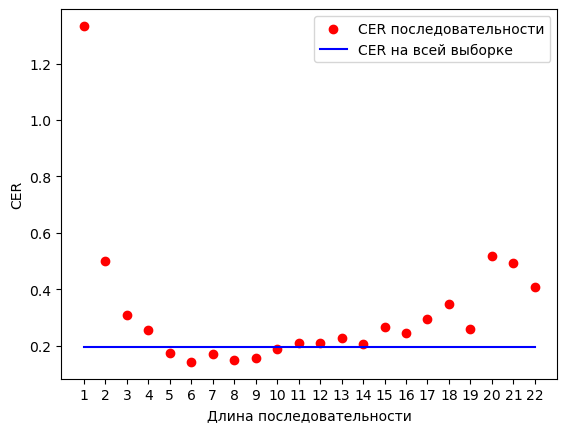

In [27]:
x = list(dict(sorted(stat[1].items())).keys())
y = dict(sorted(stat[1].items())).values()

plt.ylabel('CER')
plt.xlabel('Длина последовательности')
plt.xticks(x)
plt.scatter(x, y, color = 'red', label = 'CER последовательности')
plt.plot(x, [0.197 for i in x], color = 'blue', label = 'CER на всей выборке')
plt.legend(loc='best')

Посмотрим на этот же график на тренировочных данных. Ограничение последовательности нашей модели - 28 знаков, поэтому значение CER начало сильно увеличиваться уже после 20-21 знака

  0%|          | 0/4518 [00:00<?, ?it/s]

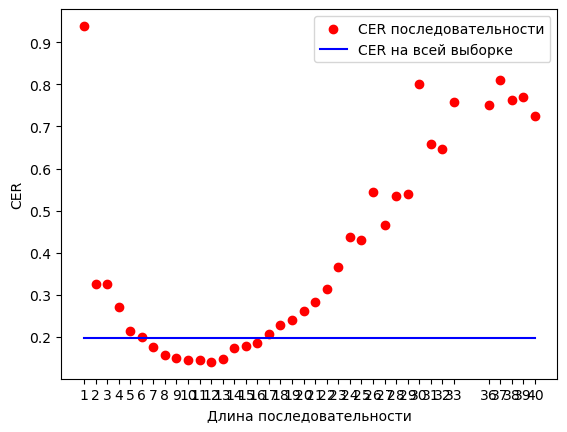

In [28]:
loader = torch.utils.data.DataLoader(train_data, batch_size = 16)
evaluator = Evaluator(model, loader, coder)
stat = evaluator.errors_sym_stat()

x = list(dict(sorted(stat[1].items())).keys())
y = dict(sorted(stat[1].items())).values()

plt.ylabel('CER')
plt.xlabel('Длина последовательности')
plt.xticks(x)
plt.scatter(x, y, color = 'red', label = 'CER последовательности')
plt.plot(x, [0.197 for i in x], color = 'blue', label = 'CER на всей выборке')
plt.legend(loc='best')

После добавления нового датасета, решил протестировать модель на новых данных. Результат оказался неплохим - CER = 0.26, WER = 0.75. То есть после добавления абсолютно новых данных сеть ухудшила показатели на 10%.

In [90]:
test_data = HWTDataset('./dataset/test/', './dataset/test.tsv', test_transform_2)
loader = torch.utils.data.DataLoader(test_data, batch_size = 16)
evaluator = Evaluator(model, loader, coder)

In [91]:
evaluator.evaluate()

  0%|          | 0/676 [00:00<?, ?it/s]

AttributeError: type object 'Image' has no attribute 'open'

Аналогично проверим результаты с коррекцией слов:

In [31]:
evaluator.evaluate(True)

  0%|          | 0/676 [00:00<?, ?it/s]

  0%|          | 0/10809 [00:00<?, ?it/s]

(tensor(0.4385), tensor(0.7472))

In [85]:
stat = evaluator.errors_sym_stat()
print(stat[0])

{'т': <filter object at 0x000002128AC6F4C0>, 'н': {'п': 41, 'е': 20, 'а': 38, 'л': 42, 'р': 27, 'о': 41, 'ч': 17, 'и': 84, 'к': 196, 'ы': 37, 'ж': 34, 'т': 38, ' ': 14, 'с': 29, 'м': 58, 'Н': 101, 'ш': 28, 'А': 16}, 'р': {'п': 27, 'е': 26, 'а': 30, 'л': 14, 'о': 19, 'и': 10, 'к': 22, 'н': 13, 'К': 23, 'т': 15, 'д': 34, 'у': 10, 'з': 18, 'А': 18, 'Р': 62}, 'а': {'п': 11, 'е': 26, 'л': 30, 'о': 83, 'и': 25, 'к': 22, 'ы': 34, 'н': 21, 'т': 21, 'с': 28, 'д': 17, 'м': 15, 'я': 42, 'з': 11, 'х': 14, 'А': 193, 'Я': 11}, 'к': {'п': 12, 'е': 11, 'а': 39, 'л': 12, 'р': 11, 'о': 14, 'н': 93, 'К': 201, 'т': 11, 'с': 24, 'х': 31}, 'г': {'п': 24, 'а': 20, 'л': 21, 'р': 19, 'о': 25, 'ч': 55, 'к': 11, 'ы': 28, 'т': 30, 'Г': 12}, 'л': {'п': 37, 'е': 38, 'а': 33, 'р': 15, 'о': 26, 'и': 56, 'к': 37, 'ы': 11, 'н': 45, 'г': 21, 'М': 10, 'т': 12, ' ': 15, 'с': 20, 'м': 116, 'я': 37, 'ш': 14, 'ь': 13, 'Л': 72}, ' ': {'п': 13, 'е': 14, 'а': 12, 'л': 15, 'о': 25, 'и': 11, 'к': 14, 'н': 17, 'К': 13, 'т': 18, 'в

ЗДЕСЬ ТЕСТОВАЯ НОВАЯ

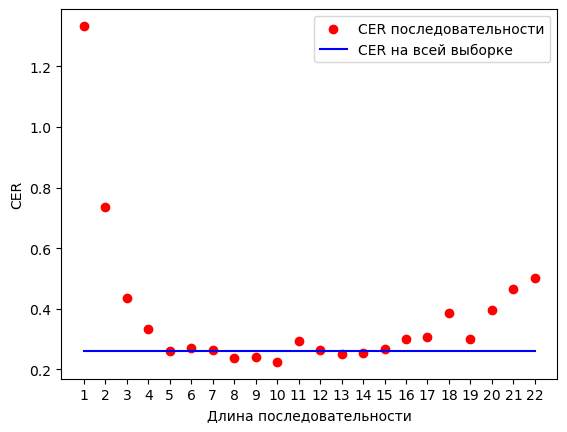

In [33]:
x = list(dict(sorted(stat[1].items())).keys())
y = dict(sorted(stat[1].items())).values()

plt.ylabel('CER')
plt.xlabel('Длина последовательности')
plt.xticks(x)
plt.scatter(x, y, color = 'red', label = 'CER последовательности')
plt.plot(x, [0.262 for i in x], color = 'blue', label = 'CER на всей выборке')
plt.legend(loc='best')

Видим, что при разных тестовых данных сеть все равно ухудшает качество распознавания на слишком коротких или слишком длинных последовательностях

In [75]:
from PIL import ImageTk, ImageDraw
from tkinter import *
import PIL

class Recognizer:
    """
    This class can recognize phrase from painted or given picture
    """
    
    def __init__(self,
                 model,
                 coder,
                 transform: Transforms,
                 device = 'cuda') -> None:
        self.model = model
        self.transform = transform
        self.device = device
        self.coder = coder
    
    
    def forward(self, img, transforms = False) -> list:
        """
        This method implements forward pass of the model

        Args:
            img (Union[Image, Tensor]): Given image to recognize.
            If Image then transforms must be True. Else it's assumed transforms have already been applied
            transforms (bool, optional): If false transforms won't be applied. Defaults to False.

        Returns:
            list: Recognized phrases. If img was Image list will contain 1 element
        """
        if transforms:
            img = self.transform(img)

        logits = self.model(img.unsqueeze(0).to(self.device))
        logits = logits.contiguous().cpu()
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T])
        probs, pos = logits.max(2)
        pos = pos.transpose(1, 0).contiguous().view(-1)
        predictions = self.coder.decode(pos.data, pred_sizes.data)
        
        return predictions
    
    
    def paint(self) -> None:
        """
        This method creates a window to paint a phrase
        """
        width = 1000  # canvas width
        height = 400 # canvas height
        center = height//2
        white = (255, 255, 255) # canvas back
        
        self.master = Tk()

        # create a tkinter canvas to draw on
        self.canvas = Canvas(self.master, width=width, height=height, bg='white')
        self.canvas.pack()

        # create an empty PIL image and draw object to draw on
        self.img = PIL.Image.new("RGB", (width, height), white)
        self.draw = ImageDraw.Draw(self.img)
        self.canvas.pack(expand=YES, fill=BOTH)
        self.canvas.bind("<B1-Motion>", self.draw_img)

        # add a button to save the image
        button=Button(text="Recognize",command=self.master.destroy)
        button.pack()
        
        self.master.mainloop()
    

    def draw_img(self, event) -> None:
        x1, y1 = (event.x - 1), (event.y - 1)
        x2, y2 = (event.x + 1), (event.y + 1)
        self.canvas.create_oval(x1, y1, x2, y2, fill="black",width=5)
        self.draw.line([x1, y1, x2, y2],fill="black",width=5)


    def recognize_from_painted(self) -> str:
        """
        This method allows you to paint phrase to recognize

        Returns:
            str: Recognized phrase
        """
        self.paint()
        prediction = self.forward(self.img, True)
        return prediction
    
    
    def recognize_from_imgs(self, imgs, correcting = False) -> list:
        """
        This method recognize pharse from given img

        Args:
            img (Tensor): Transformed imgs you want to recognize
            correcting (bool, optional): If you want to correct predicted word with dictionary. Defaults to False.

        Returns:
            list: List of recognized phrases
        """
        predictions = self.forward(imgs)
        
        if correcting: 
            evaluator = Evaluator(self.model, None, self.coder)
            predictions = evaluator.word_correction(predictions)
            
        return predictions

    
    def recognize_from_file(self, path, correcting = False) -> str:
        """
        This method loads img from given then recognize it

        Args:
            path (str): Path to img
            correcting (bool, optional): If you want to correct predicted word with dictionary. Defaults to False.

        Returns:
            str: Recognized phrase
        """
        img = PIL.Image.open(path)
        prediction = self.forward(img, True)
        
        if correcting: 
            evaluator = Evaluator(self.model, None, self.coder)
            prediction = evaluator.word_correction(prediction)
            
        return prediction

In [76]:
rec = Recognizer(model, coder, test_transform_2)

In [77]:
rec.recognize_from_file('./Модель.png')

'модель'

In [36]:
stat[0]

{'и': {'л': 11, 'е': 16, 'н': 22},
 'о': {'е': 12, 'а': 34},
 'я': {'е': 11},
 'с': {'е': 20},
 'н': {'п': 10, 'к': 16, 'м': 18},
 'а': {'о': 11},
 'е': {'и': 17, 'с': 12, 'я': 10},
 'к': {'н': 19, 'х': 11},
 'г': {'т': 10},
 'л': {'м': 12}}

In [39]:
def __filter_errors(elem):
        return elem[1] >= 15
    

def errors_sym_stat(a, num_matches = 15):
    
    # Leave only signficant errors
    for pred_sym in a.keys():
        if isinstance(a[pred_sym], dict):
            a[pred_sym] = dict(filter(__filter_errors, a[pred_sym].items()))
        
    a = dict(filter(lambda x: len(x[1]) > 0, a.items()))
    
    return a

errors_sym_stat(stat[0].copy())

{'и': {'е': 16, 'н': 22},
 'о': {'а': 34},
 'с': {'е': 20},
 'н': {'к': 16, 'м': 18},
 'е': {'и': 17},
 'к': {'н': 19}}